In [1]:
import folium
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import box
import numpy as np
import plotly.express as px
from scipy.spatial.distance import cdist
import plotly.graph_objects as go
from shapely.geometry import Point, Polygon
import random
from shapely.ops import nearest_points
from scipy.spatial import distance
import optuna
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from pyproj import Proj, transform, CRS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

C:\Users\1qlqj\Desktop\multicamp_semi\multicamp_semi\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.font_manager as fm

# 한국어 출력을 위한 폰트 설정
plt.rc('font', family='NanumGothic') 

# 마이너스 기호가 깨지는 것을 방지
plt.rcParams['axes.unicode_minus'] = False

### 데이터로드

In [3]:
# 비상소화장치 위치(최신)
bisang = pd.read_excel("data/(송파소방서)비상소화장치.xlsx")
bisang = bisang.drop(columns=['순번', '일련번호', '장치번호', '좌표X', '좌표Y'])
bisang.head(3)

C:\Users\1qlqj\Desktop\multicamp_semi\multicamp_semi\venv\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,설치지역,설치구분,설치유형구분,사용구분,관할서,안전센터,주소,상세위치,경위도좌표X,경위도좌표Y
0,소방차진입곤란,소방서,일체형,양호,송파소방서,거여119안전센터,송파구 성내천로63길 5,공중전화 옆 좌측 1m,127.15741,37.490364
1,주거지역,소방서,일체형,양호,송파소방서,방이119안전센터,송파구 천호대로152길 7,전면 40m,127.12222,37.537875
2,시장지역,소방서,일체형,양호,송파소방서,거여119안전센터,송파구 성내천로30길 19,한사랑교회 후면 5m,127.15031,37.498358


In [4]:
# 도로폭 데이터(최신이지만, 도로폭 자체는 정확하지 않다.)
road = pd.read_csv("data/도로폭_점수.csv")
road = road.drop(columns=['Unnamed: 0'])
road.head(3)

,geometry,approx_width,width_score
0,"POLYGON ((127.09667064071128 37.5321922617835,...",0.680039,6.0
1,POLYGON ((127.09655573612763 37.53210120979733...,0.748713,6.0
2,POLYGON ((127.0676680824207 37.519966901557744...,0.003889,6.0


In [5]:
# 소방서, 안전센터 좌표(최신)
sobang = pd.read_csv("data/송파구 소방서 안전센터 좌표.csv", encoding='cp949')
sobang.head(3)

,센터명,위도,경도
0,종합운동장119안전센터,37.513567,127.083810
1,잠실119안전센터,37.514113,127.099505
2,거여119안전센터,37.491833,127.148908


In [6]:
# 주택현황(2020)
house = pd.read_csv("data/송파구/2020_송파구_주택.csv", encoding='cp949')
house = house.drop(columns=['시점', '아파트'])
house.head(3)

,동,소계,단독주택,연립주택,다세대주택,비거주용건물내주택
0,풍납1동,3296,892,204,562,42
1,풍납2동,7608,499,178,1341,55
2,거여1동,3552,410,212,1345,43


In [7]:
# 고령자 현황
old = pd.read_csv("data/송파구/2021-2023_송파구_고령자현황.csv", encoding='cp949')
old = old[old['시점'] == 2023]
old.head(3)

,시점,동,전체인구,65세이상 인구
54,2023,풍납1동,12286,2890
55,2023,풍납2동,23918,4222
56,2023,거여1동,12100,2619


In [8]:
# 골든타임 넘어서 도착한 화재 건수
time = pd.read_csv("data/화재출동_골든타임.csv")
time = time.drop(columns=['index'])
time = time[time['시군구명'] == '송파구']
time.head(3)

,사망수,부상자수,재산피해금액,출동소요시간,화재진압시간,시군구명,읍면동명,경도,위도,현장소방서거리,...,시간단위강수량,시간단위풍속,시간단위풍향,시간단위습도,시간단위적설량,시간단위가시거리,계절,시간대,화재발생일시,주말여부
8,0,0,50,423,414,송파구,송파동,127.110858,37.509305,4.0,...,NaN,0.5,290.0,48.0,NaN,2000,겨울,밤,2021-01-04 00:09:00,평일
15,0,0,48,420,900,송파구,잠실동,127.081745,37.508556,6.0,...,NaN,4.8,290.0,34.0,NaN,2000,겨울,낮,2021-01-05 13:19:00,평일
38,0,0,86,443,900,송파구,석촌동,127.110539,37.500342,6.0,...,NaN,1.6,50.0,92.0,5.1,196,겨울,밤,2021-01-12 22:55:00,평일


## 송파구 비상소화장치 제안 위치 데이터 프레임 생성

In [9]:
# 비상소화장치 제안 위치 데이터
data = {
    '동': [
        '잠실동', '잠실동',
        '삼전동', '삼전동', '삼전동',
        '석촌동', '석촌동',
        '송파동',
        '방이동', '방이동',
        '가락동', '가락동',
        '송파동',
        '마천동',
        '마천동',
        '거여동', '거여동',
        '오금동', '오금동'
    ],
    '위도': [
        37.5085071, 37.50511389,
        37.50231025, 37.50094046, 37.504103,
        37.49991962, 37.50097974,
        37.50884075,
        37.51174, 37.51299316,
        37.499000, 37.496917,
        37.500694,
        37.492321,
        37.499138,
        37.493358, 37.497698,
        37.503962, 37.502313
    ],
    '경도': [
        127.0825862, 127.0817572,
        127.0901942, 127.0936817, 127.090679,
        127.0974103, 127.1000492,
        127.1087034,
        127.110053, 127.1161285,
        127.120611, 127.120417,
        127.112639,
        127.154682,
        127.149098,
        127.142836, 127.143332,
        127.140793, 127.134786
    ],
    '관할구역': [
        '잠실 안전센터', '잠실 안전센터',
        '잠실 안전센터', '잠실 안전센터', '잠실 안전센터',
        '잠실 안전센터', '잠실 안전센터',
        '종합운동장 안전센터',
        '방이 안전센터', '방이 안전센터',
        '가락 안전센터', '가락 안전센터',
        '가락 안전센터',
        '거여 안전센터',
        '거여 안전센터',
        '거여 안전센터', '거여 안전센터',
        '서울 송파 소방서', '서울 송파 소방서'
    ]
}

# 데이터프레임 생성
df = pd.DataFrame(data)

In [10]:
df.head()

,동,위도,경도,관할구역
0,잠실동,37.508507,127.082586,잠실 안전센터
1,잠실동,37.505114,127.081757,잠실 안전센터
2,삼전동,37.502310,127.090194,잠실 안전센터
3,삼전동,37.500940,127.093682,잠실 안전센터
4,삼전동,37.504103,127.090679,잠실 안전센터


In [11]:
# 각 제안위치의 id 추가
df['id'] = range(1, len(df) + 1)
df.head(2)

,동,위도,경도,관할구역,id
0,잠실동,37.508507,127.082586,잠실 안전센터,1
1,잠실동,37.505114,127.081757,잠실 안전센터,2


## 동데이터와 결합
### 전처리

In [12]:
# old와 house의 동 이름을 df의 동 이름으로 매핑하는 사전 정의
mapping_to_df = {
    '풍납1동': '풍납동', '풍납2동': '풍납동',
    '거여1동': '거여동', '거여2동': '거여동',
    '마천1동': '마천동', '마천2동': '마천동',
    '방이1동': '방이동', '방이2동': '방이동',
    '오륜동': '오금동',
    '송파1동': '송파동', '송파2동': '송파동',
    '잠실본동': '잠실동', '잠실1동': '잠실동', '잠실2동': '잠실동', '잠실3동': '잠실동', '잠실4동': '잠실동', '잠실6동': '잠실동', '잠실7동': '잠실동',
    '가락본동': '가락동', '가락1동': '가락동', '가락2동': '가락동',
    '문정1동': '문정동', '문정2동': '문정동',
    '장지동': '장지동',
    '위례동': '위례동',
    '삼전동': '삼전동'
}

In [13]:
# 매핑 적용
old['동'] = old['동'].map(mapping_to_df).fillna(old['동']) 
house['동'] = house['동'].map(mapping_to_df).fillna(house['동'])  

In [14]:
# 'X'를 0으로 변환
house.replace('X', 0, inplace=True)

In [15]:
# 데이터 타입을 숫자로 변환
for col in ['소계', '단독주택', '연립주택', '다세대주택', '비거주용건물내주택']:
    house[col] = pd.to_numeric(house[col])

In [16]:
# 같은 동끼리 값 더하기
old = old.groupby('동').sum().reset_index()
house = house.groupby('동').sum().reset_index()

### 데이터프레임 결합

In [17]:
# 주택현황과 인구 결합
df_old_house = pd.merge(old, house, on='동', how='inner')
df_old_house.head(2)

,동,시점,전체인구,65세이상 인구,소계,단독주택,연립주택,다세대주택,비거주용건물내주택
0,가락동,6069,84548,13047,28550,605,419,6194,224
1,거여동,4046,35753,7194,8934,716,273,1889,72


In [18]:
# 원래 데이터와 결합
df = pd.merge(df, df_old_house, on='동', how='left')
df

,동,위도,경도,관할구역,id,시점,전체인구,65세이상 인구,소계,단독주택,연립주택,다세대주택,비거주용건물내주택
0,잠실동,37.508507,127.082586,잠실 안전센터,1,12138,144615,23163,47306,593,124,7576,145
1,잠실동,37.505114,127.081757,잠실 안전센터,2,12138,144615,23163,47306,593,124,7576,145
2,삼전동,37.502310,127.090194,잠실 안전센터,3,2023,29451,4363,11497,477,284,10168,89
3,삼전동,37.500940,127.093682,잠실 안전센터,4,2023,29451,4363,11497,477,284,10168,89
4,삼전동,37.504103,127.090679,잠실 안전센터,5,2023,29451,4363,11497,477,284,10168,89
5,석촌동,37.499920,127.097410,잠실 안전센터,6,2023,31333,4951,12091,510,423,9931,161
6,석촌동,37.500980,127.100049,잠실 안전센터,7,2023,31333,4951,12091,510,423,9931,161
7,송파동,37.508841,127.108703,종합운동장 안전센터,8,4046,42328,6901,15918,525,548,8873,130
8,방이동,37.511740,127.110053,방이 안전센터,9,4046,42064,6282,13135,469,931,8198,179
9,방이동,37.512993,127.116129,방이 안전센터,10,4046,42064,6282,13135,469,931,8198,179


- 주택수를 다 더한게 소계와 같지 않아서 제거하기로함.

In [19]:
df = df.drop(columns=['시점', '단독주택', '연립주택',	'다세대주택', '비거주용건물내주택'])

In [20]:
df.rename(columns={'소계': '주택수'}, inplace=True)

In [21]:
df

,동,위도,경도,관할구역,id,전체인구,65세이상 인구,주택수
0,잠실동,37.508507,127.082586,잠실 안전센터,1,144615,23163,47306
1,잠실동,37.505114,127.081757,잠실 안전센터,2,144615,23163,47306
2,삼전동,37.502310,127.090194,잠실 안전센터,3,29451,4363,11497
3,삼전동,37.500940,127.093682,잠실 안전센터,4,29451,4363,11497
4,삼전동,37.504103,127.090679,잠실 안전센터,5,29451,4363,11497
5,석촌동,37.499920,127.097410,잠실 안전센터,6,31333,4951,12091
6,석촌동,37.500980,127.100049,잠실 안전센터,7,31333,4951,12091
7,송파동,37.508841,127.108703,종합운동장 안전센터,8,42328,6901,15918
8,방이동,37.511740,127.110053,방이 안전센터,9,42064,6282,13135
9,방이동,37.512993,127.116129,방이 안전센터,10,42064,6282,13135


## 현재 설치된 비상소화장치와의 결합

In [22]:
bisang = bisang.drop(columns=['설치지역', '설치구분', '설치유형구분', '사용구분', '관할서', '안전센터', '주소', '상세위치'])

In [23]:
# 거리 구하기 공식
def haversine(lon1, lat1, lon2, lat2):

    # 지구 반지름 (킬로미터 단위)
    R = 6371.0

    # 라디안 단위로 변환
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # 경도와 위도의 차이
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # 하버사인 공식
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # 결과 거리
    distance = R * c
    return distance

In [24]:
# 각 제안 위치에서 가장 가까운 비상소화장치까지의 거리와 설치지역 유형 계산
closest_distances = []
closest_types = []

for index, row in df.iterrows():
    distances = bisang.apply(lambda x: haversine(row['경도'], row['위도'], x['경위도좌표X'], x['경위도좌표Y']), axis=1)
    closest_idx = distances.idxmin()
    closest_distances.append(distances[closest_idx])
    closest_types.append(bisang.loc[closest_idx])

# 가장 가까운 비상소화장치까지의 거리를 df에 추가
df['가장_가까운_비상소화장치_거리'] = closest_distances

In [25]:
# 가장 가까운 비상소화장치의 설치지역 유형을 df에 추가
closest_types_df = pd.DataFrame(closest_types).reset_index(drop=True)
df = pd.concat([df, closest_types_df], axis=1)

In [26]:
df = df.drop(columns=['경위도좌표X', '경위도좌표Y'])

In [27]:
df.head(3)

,동,위도,경도,관할구역,id,전체인구,65세이상 인구,주택수,가장_가까운_비상소화장치_거리
0,잠실동,37.508507,127.082586,잠실 안전센터,1,144615,23163,47306,0.181221
1,잠실동,37.505114,127.081757,잠실 안전센터,2,144615,23163,47306,0.476481
2,삼전동,37.502310,127.090194,잠실 안전센터,3,29451,4363,11497,0.853448


## 소방서, 안전센터와의 거리 결합

In [28]:
# 각 제안 위치에서 가장 가까운 소방서까지의 거리 계산
closest_sobang_distances = []

for index, row in df.iterrows():
    # 각 df 위치와 sobang 위치들 사이의 거리 계산
    distances = sobang.apply(lambda x: haversine(row['위도'], row['경도'], x['위도'], x['경도']), axis=1)
    # 가장 가까운 거리 찾기
    closest_distance = distances.min()
    closest_sobang_distances.append(closest_distance)

# 가장 가까운 소방서까지의 거리를 df에 추가
df['가장_가까운_소방서_거리'] = closest_sobang_distances

## 골든타임 넘어서 도착한 건물화재사고와 거리 결합

In [29]:
# 가장 가까운 화재 사건과의 거리를 df에 추가
closest_fire_distances = []

for index, row in df.iterrows():
    # 각 df 위치와 time 위치들 사이의 거리 계산
    distances = time.apply(lambda x: haversine(row['위도'], row['경도'], x['위도'], x['경도']), axis=1)
    # 가장 가까운 화재 사건까지의 거리
    closet_distance = distances.min()
    closest_fire_distances.append(closet_distance)

# 가장 가까운 화재 사건까지의 거리를 df에 추가
df['가장_가까운_화재_거리'] = closest_fire_distances

In [30]:
df

,동,위도,경도,관할구역,id,전체인구,65세이상 인구,주택수,가장_가까운_비상소화장치_거리,가장_가까운_소방서_거리,가장_가까운_화재_거리
0,잠실동,37.508507,127.082586,잠실 안전센터,1,144615,23163,47306,0.181221,0.365537,0.093627
1,잠실동,37.505114,127.081757,잠실 안전센터,2,144615,23163,47306,0.476481,0.611004,0.133518
2,삼전동,37.502310,127.090194,잠실 안전센터,3,29451,4363,11497,0.853448,1.036168,0.113655
3,삼전동,37.500940,127.093682,잠실 안전센터,4,29451,4363,11497,1.116636,1.095328,0.360213
4,삼전동,37.504103,127.090679,잠실 안전센터,5,29451,4363,11497,0.703036,0.993010,0.231809
5,석촌동,37.499920,127.097410,잠실 안전센터,6,31333,4951,12091,0.783507,0.980019,0.270597
6,석촌동,37.500980,127.100049,잠실 안전센터,7,31333,4951,12091,0.560094,0.882933,0.069820
7,송파동,37.508841,127.108703,종합운동장 안전센터,8,42328,6901,15918,0.584844,1.082212,0.241582
8,방이동,37.511740,127.110053,방이 안전센터,9,42064,6282,13135,0.885568,1.183621,0.104522
9,방이동,37.512993,127.116129,방이 안전센터,10,42064,6282,13135,1.136727,0.918803,0.064139


## 골든타임 넘겨 도착한 화재사고와의 결합

In [31]:
# df와 road를 GeoDataFrame으로 변환
gdf = gpd.GeoDataFrame(df, geometry=[Point(xy) for xy in zip(df['경도'], df['위도'])], crs="EPSG:4326")
road_gdf = gpd.GeoDataFrame(road, geometry=gpd.GeoSeries.from_wkt(road['geometry']), crs="EPSG:4326")

In [32]:
# 각 제안 위치에서 1200m 내에 있는 도로 폭 데이터 계산
results = []
for geometry in gdf.geometry:
    # 200m 버퍼 생성, 버퍼: 주어진 지리적 객체로부터 일정 거리 내에 있는 영
    buffer_200m = geometry.buffer(0.002)  # 대략적인 거리 변환, 실제 거리 변환을 위해서는 좀 더 정확한 계산 필요

    # 버퍼 내 도로 폭 데이터 필터링
    roads_within_200m = road_gdf[road_gdf.geometry.intersects(buffer_200m)]
    
    # 결과 저장
    results.append({
        '200m_내_좁은도로_수': roads_within_200m.shape[0],
        '200m_내_도로폭_점수_평균': roads_within_200m['width_score'].mean() if not roads_within_200m.empty else 0
    })

# 결과를 DataFrame으로 변환하고 df에 합치기
results_df = pd.DataFrame(results)
df = pd.concat([df.reset_index(drop=True), results_df], axis=1)

In [33]:
df

,동,위도,경도,관할구역,id,전체인구,65세이상 인구,주택수,가장_가까운_비상소화장치_거리,가장_가까운_소방서_거리,가장_가까운_화재_거리,200m_내_좁은도로_수,200m_내_도로폭_점수_평균
0,잠실동,37.508507,127.082586,잠실 안전센터,1,144615,23163,47306,0.181221,0.365537,0.093627,2,1.000000
1,잠실동,37.505114,127.081757,잠실 안전센터,2,144615,23163,47306,0.476481,0.611004,0.133518,1,1.000000
2,삼전동,37.502310,127.090194,잠실 안전센터,3,29451,4363,11497,0.853448,1.036168,0.113655,1,5.000000
3,삼전동,37.500940,127.093682,잠실 안전센터,4,29451,4363,11497,1.116636,1.095328,0.360213,2,5.500000
4,삼전동,37.504103,127.090679,잠실 안전센터,5,29451,4363,11497,0.703036,0.993010,0.231809,0,0.000000
5,석촌동,37.499920,127.097410,잠실 안전센터,6,31333,4951,12091,0.783507,0.980019,0.270597,0,0.000000
6,석촌동,37.500980,127.100049,잠실 안전센터,7,31333,4951,12091,0.560094,0.882933,0.069820,1,6.000000
7,송파동,37.508841,127.108703,종합운동장 안전센터,8,42328,6901,15918,0.584844,1.082212,0.241582,0,0.000000
8,방이동,37.511740,127.110053,방이 안전센터,9,42064,6282,13135,0.885568,1.183621,0.104522,0,0.000000
9,방이동,37.512993,127.116129,방이 안전센터,10,42064,6282,13135,1.136727,0.918803,0.064139,0,0.000000


# 제안위치 우선순위 예측하기

### 스케일링

In [34]:
# 숫자 열 선택
numeric_columns = ['전체인구', '65세이상 인구', '주택수', '가장_가까운_비상소화장치_거리', '가장_가까운_소방서_거리', '가장_가까운_화재_거리', '200m_내_좁은도로_수', '200m_내_도로폭_점수_평균']

# Min-Max 스케일러 생성
scaler = MinMaxScaler()

# 숫자 열 스케일링
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

### K-평균 클러스터링

In [35]:
# 관심 있는 특성 선택 (위도와 경도 제외)
X = df[['전체인구', '65세이상 인구', '주택수', '가장_가까운_비상소화장치_거리', '가장_가까운_소방서_거리', '가장_가까운_화재_거리', '200m_내_좁은도로_수', '200m_내_도로폭_점수_평균']].values

In [36]:
# 반복 횟수 설정
# num_iterations = 100  # 원하는 횟수로 설정

# 최적의 실루엣 점수 및 해당하는 가중치 초기화
# best_silhouette_score = float('-inf')
# best_weights = None

# 반복적으로 실험 실행
# for _ in range(num_iterations):
    # 랜덤하게 가중치 생성
    # weights = [random.uniform(0.1, 3) for _ in range(8)] 
    
    # 특성과 가중치를 곱하여 새로운 가중치를 적용한 특성 생성
    # X_weighted = X * np.array(weights)

    # 클러스터 범위 설정
    # cluster_range = range(2, 10)  

    # 실루엣 점수 저장 리스트
    # silhouette_scores = []

    # 클러스터 개수에 따른 모델 생성 및 실루엣 점수 계산
    # for n_clusters in cluster_range:
        # kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        # cluster_labels = kmeans.fit_predict(X_weighted)
        # silhouette_avg = silhouette_score(X_weighted, cluster_labels)
        # silhouette_scores.append(silhouette_avg)

    # 최적의 실루엣 점수와 가중치 업데이트
    # if max(silhouette_scores) > best_silhouette_score:
        # best_silhouette_score = max(silhouette_scores)
        # best_weights = weights

# 최적의 실루엣 점수와 해당하는 가중치 출력
# print("Best Silhouette Score:", best_silhouette_score)
# print("Best Weights:", best_weights)

Best Silhouette Score: 0.6776740571027703
Best Weights: [2.7371932296825134, 0.9403614969298697, 2.5629538485756345, 0.15099877071216614, 0.6245617013927515, 0.2860494270326206, 2.6115399965250776, 0.11303724608591137]

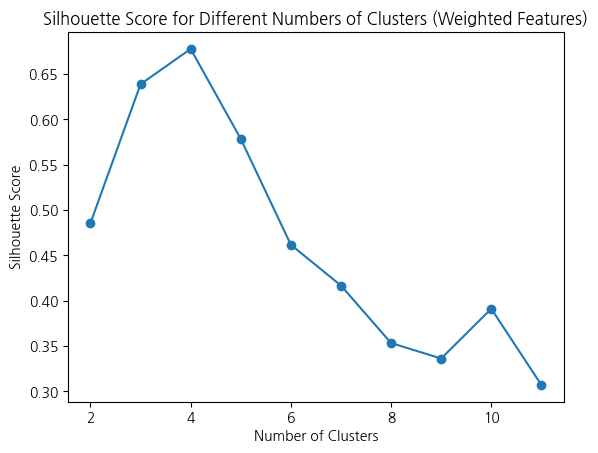

In [37]:
# 특성에 대한 가중치 정의
weights = [2.7371932296825134, 0.9403614969298697, 2.5629538485756345, 0.15099877071216614, 0.6245617013927515, 0.2860494270326206, 2.6115399965250776, 0.11303724608591137]
# 특성과 가중치를 곱하여 새로운 가중치를 적용한 특성 생성
X_weighted = X * weights

# 클러스터 범위 설정
cluster_range = range(2, 12)  

# 실루엣 점수 저장 리스트
silhouette_scores = []

# 클러스터 개수에 따른 모델 생성 및 실루엣 점수 계산
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_weighted)
    silhouette_avg = silhouette_score(X_weighted, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# 살루엣 점수 그래프로 표시
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters (Weighted Features)')
plt.show()

4개일때 점수가 가장높다.

In [38]:
# 선택한 가중치를 적용한 특성으로 클러스터링 수행
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(X_weighted)

# 클러스터링 결과를 평가하기 위해 실루엣 점수 계산
silhouette_avg = silhouette_score(X_weighted, cluster_labels)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.6776740571027703


In [39]:
# 클러스터 중심점
centers = kmeans.cluster_centers_

# 클러스터 중심점을 DataFrame으로 변환
centers_df = pd.DataFrame(centers, columns=['전체인구', '65세이상 인구', '주택수', '가장_가까운_비상소화장치_거리', '가장_가까운_소방서_거리', '가장_가까운_화재_거리', '200m_내_좁은도로_수', '200m_내_도로폭_점수_평균'])

centers_df

,전체인구,65세이상 인구,주택수,가장_가까운_비상소화장치_거리,가장_가까운_소방서_거리,가장_가까운_화재_거리,200m_내_좁은도로_수,200m_내_도로폭_점수_평균
0,0.174227,0.095505,0.247010,0.085642,0.454741,0.075784,0.271329,0.039677
1,0.306866,0.199939,0.305157,0.044827,0.160996,0.161317,2.518271,0.060668
2,2.737193,0.940361,2.562954,0.030516,0.198187,0.020330,0.559616,0.018840
3,1.309534,0.434367,1.310198,0.107678,0.511670,0.013621,0.373077,0.018840


각 클러스터의 특성 확인

| 클러스터 | 전체인구     | 65세 이상 인구    | 주택수        | 가장 가까운 비상소화장치 거리 | 가장 가까운 소방서 거리  | 가장 가까운 화재 거리  | 200m 내 좁은 도로 수  | 200m 내 도로폭 점수 평균  |
|--------|---------------|------------------|-------------|----------------------------|------------------------|----------------------|---------------------|-------------------------|
| 0      | 매우 낮음     | 낮음             | 낮음        | 높음                       | 높음                   | 높음                 | 매우 낮음          | 매우 낮음              |
| 1      | 낮음         | 낮음에서 중간 정도 | 낮음에서 중간 정도 | 중간 정도                | 낮음에서 중간 정도     | 낮음에서 중간 정도   | 높음               | 높음                    |
| 2      | 매우 높음    | 높음             | 매우 높음    | 매우 낮음                   | 낮음                   | 매우 낮음            | 낮음               | 낮음                    |
| 3      | 중간 정도     | 중간 정도       | 중간 정도    | 높음에서 중간 정도          | 높음                   | 매우 낮음            | 낮음에서 중간 정도  | 낮음에서 중간 정도       |


In [40]:
df['클러스터'] = cluster_labels

In [41]:
# 숫자형 데이터에 대해서만 집계 함수 적용
numeric_cols = df.select_dtypes(include=[np.number]).columns
cluster_stats = df.groupby('클러스터')[numeric_cols].agg(['mean', 'median'])

In [42]:
cluster_stats

위도                     경도                     id         \
           mean     median        mean      median       mean median   
클러스터                                                                   
0     37.503331  37.502310  127.112147  127.108703   9.272727    8.0   
1     37.498669  37.499196  127.137861  127.142063  15.500000   15.5   
2     37.506810  37.506810  127.082172  127.082172   1.500000    1.5   
3     37.497959  37.497959  127.120514  127.120514  11.500000   11.5   

          전체인구            65세이상 인구            ... 가장_가까운_소방서_거리            \
          mean    median      mean    median  ...          mean    median   
클러스터                                          ...                           
0     0.063652  0.054722  0.101562  0.102074  ...      0.728097  0.800108   
1     0.112110  0.083820  0.212620  0.194973  ...      0.257774  0.280972   
2     1.000000  1.000000  1.000000  1.000000  ...      0.317322  0.317322   
3     0.478422  0.478422  0.461915  0.461915  ...      0.819247  0.819247   

     가장_가까운_화재_거리           200m_내_좁은도로_수           200m_내_도로폭_점수_평균  \
             mean    median          mean    median             mean   
클러스터                                                                   
0        0.264934  0.190425      0.103896  0.000000         0.351010   
1        0.563949  0.531199      0.964286  1.000000         0.536706   
2        0.071071  0.071071      0.214286  0.214286         0.166667   
3        0.047618  0.047618      0.142857  0.142857         0.166667   

               클러스터         
        median mean median  
클러스터                        
0     0.000000  0.0    0.0  
1     0.452381  1.0    1.0  
2     0.166667  2.0    2.0  
3     0.166667  3.0    3.0  

[4 rows x 24 columns]

### PCA를 사용한 클러스터링 결과 시각화

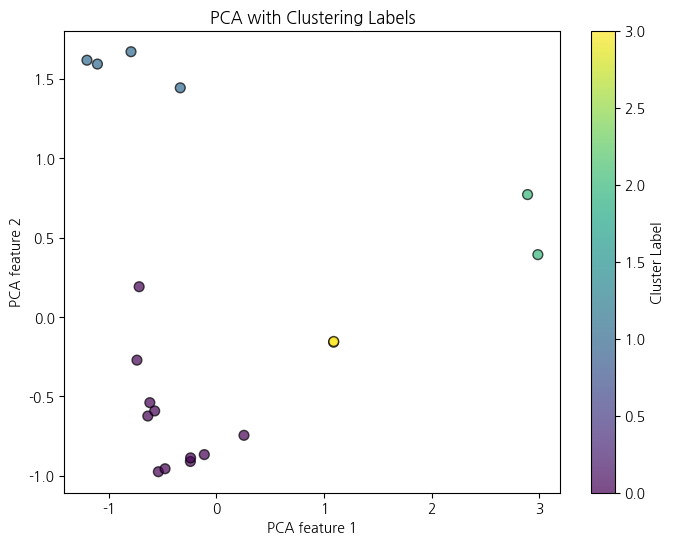

In [43]:
from sklearn.decomposition import PCA

# PCA 모델을 사용하여 차원 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_weighted)

# 클러스터링 결과 시각화
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.7)
plt.title('PCA with Clustering Labels')
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

### 클러스터링 결과의 지도 시각화

In [44]:
import folium

map_center_lat, map_center_lon = df['위도'].mean(), df['경도'].mean()

# Folium 지도 객체 생성
map = folium.Map(location=[map_center_lat, map_center_lon], zoom_start=12)

# 클러스터링 결과를 지도에 추가
for lat, lon, cluster in zip(df['위도'], df['경도'], cluster_labels):
    color = 'blue' if cluster == 0 else 'red' if cluster == 1 else 'green' if cluster == 2 else 'black' if cluster == 3 else 'purple'
    fill_color = 'blue' if cluster == 0 else 'red' if cluster == 1 else 'green' if cluster == 2 else 'black' if cluster == 3 else 'purple'
    folium.CircleMarker(
        location=[lat, lon],
        radius=5,
        popup=f'Cluster: {cluster}',
        color=color,
        fill=True,
        fill_color=fill_color
    ).add_to(map)

# 지도 표시
map

In [45]:
df

,동,위도,경도,관할구역,id,전체인구,65세이상 인구,주택수,가장_가까운_비상소화장치_거리,가장_가까운_소방서_거리,가장_가까운_화재_거리,200m_내_좁은도로_수,200m_내_도로폭_점수_평균,클러스터
0,잠실동,37.508507,127.082586,잠실 안전센터,1,1.000000,1.000000,1.000000,0.056290,0.196826,0.050937,0.285714,0.166667,2
1,잠실동,37.505114,127.081757,잠실 안전센터,2,1.000000,1.000000,1.000000,0.347905,0.437818,0.091205,0.142857,0.166667,2
2,삼전동,37.502310,127.090194,잠실 안전센터,3,0.000000,0.000000,0.066793,0.720218,0.855234,0.071154,0.142857,0.833333,0
3,삼전동,37.500940,127.093682,잠실 안전센터,4,0.000000,0.000000,0.066793,0.980157,0.913315,0.320044,0.285714,0.916667,0
4,삼전동,37.504103,127.090679,잠실 안전센터,5,0.000000,0.000000,0.066793,0.571663,0.812862,0.190425,0.000000,0.000000,0
5,석촌동,37.499920,127.097410,잠실 안전센터,6,0.016342,0.031277,0.082274,0.651141,0.800108,0.229581,0.000000,0.000000,0
6,석촌동,37.500980,127.100049,잠실 안전센터,7,0.016342,0.031277,0.082274,0.430486,0.704792,0.026904,0.142857,1.000000,0
7,송파동,37.508841,127.108703,종합운동장 안전센터,8,0.111814,0.135000,0.182008,0.454930,0.900438,0.200291,0.000000,0.000000,0
8,방이동,37.511740,127.110053,방이 안전센터,9,0.109522,0.102074,0.109481,0.751942,1.000000,0.061935,0.000000,0.000000,0
9,방이동,37.512993,127.116129,방이 안전센터,10,0.109522,0.102074,0.109481,1.000000,0.740008,0.021170,0.000000,0.000000,0


## 우선순위 정하기
X = df[['전체인구', '65세이상 인구', '주택수', '가장_가까운_비상소화장치_거리', '가장_가까운_소방서_거리', '가장_가까운_화재_거리', '200m_내_좁은도로_수', '200m_내_도로폭_점수_평균']]

- 클수록 우선순위가 높은 것: 전체인구, 65세 이상인구, 주택수, 가장 가까운 비상소화장치거리, 가장 가까운 소방서거리, 200m내 좁은 도로수
- 작을수록 우선순위가 높은 것: 가장 가까운 화재거리, 200m내 도로폭 점수평균

In [46]:
weights_adjusted = [2.7371932296825134, 0.9403614969298697, 2.5629538485756345, 0.15099877071216614, 0.6245617013927515, - 0.2860494270326206, 2.6115399965250776, - 0.11303724608591137]

In [47]:
# 숫자형 데이터 열만 선택
numeric_cols = df.select_dtypes(include=[np.number])

# 선택된 숫자형 데이터 열에 대해서만 클러스터별 평균값 계산
cluster_means = numeric_cols.groupby(df['클러스터']).mean()
cluster_means = cluster_means.drop(columns=['위도', '경도', '클러스터', 'id'])
cluster_means

,전체인구,65세이상 인구,주택수,가장_가까운_비상소화장치_거리,가장_가까운_소방서_거리,가장_가까운_화재_거리,200m_내_좁은도로_수,200m_내_도로폭_점수_평균
클러스터,,,,,,,,
0,0.063652,0.101562,0.096377,0.567170,0.728097,0.264934,0.103896,0.351010
1,0.112110,0.212620,0.119065,0.296870,0.257774,0.563949,0.964286,0.536706
2,1.000000,1.000000,1.000000,0.202097,0.317322,0.071071,0.214286,0.166667
3,0.478422,0.461915,0.511206,0.713108,0.819247,0.047618,0.142857,0.166667


In [48]:
# 가중치 적용
weighted_cluster_means = cluster_means * weights_adjusted
weighted_cluster_means

,전체인구,65세이상 인구,주택수,가장_가까운_비상소화장치_거리,가장_가까운_소방서_거리,가장_가까운_화재_거리,200m_내_좁은도로_수,200m_내_도로폭_점수_평균
클러스터,,,,,,,,
0,0.174227,0.095505,0.247010,0.085642,0.454741,-0.075784,0.271329,-0.039677
1,0.306866,0.199939,0.305157,0.044827,0.160996,-0.161317,2.518271,-0.060668
2,2.737193,0.940361,2.562954,0.030516,0.198187,-0.020330,0.559616,-0.018840
3,1.309534,0.434367,1.310198,0.107678,0.511670,-0.013621,0.373077,-0.018840


In [49]:
# 종합 점수 계산 (가중치 적용된 평균값의 합계)
cluster_priority_scores = weighted_cluster_means.sum(axis=1)
cluster_priority_scores

클러스터
0    1.212992
1    3.314071
2    6.989658
3    4.014063
dtype: float64

In [50]:
# 우선순위 정하기
cluster_priority = cluster_priority_scores.sort_values(ascending=False).index
print("클러스터 우선순위:", cluster_priority)

클러스터 우선순위: Index([2, 3, 1, 0], dtype='int32', name='클러스터')


In [51]:
# 클러스터별 우선순위 매핑
priority_mapping = {2: 1, 3: 2, 1: 3, 0: 4}

# '클러스터' 열을 사용하여 '우선순위' 열 생성
df['우선순위'] = df['클러스터'].map(priority_mapping)
df

,동,위도,경도,관할구역,id,전체인구,65세이상 인구,주택수,가장_가까운_비상소화장치_거리,가장_가까운_소방서_거리,가장_가까운_화재_거리,200m_내_좁은도로_수,200m_내_도로폭_점수_평균,클러스터,우선순위
0,잠실동,37.508507,127.082586,잠실 안전센터,1,1.000000,1.000000,1.000000,0.056290,0.196826,0.050937,0.285714,0.166667,2,1
1,잠실동,37.505114,127.081757,잠실 안전센터,2,1.000000,1.000000,1.000000,0.347905,0.437818,0.091205,0.142857,0.166667,2,1
2,삼전동,37.502310,127.090194,잠실 안전센터,3,0.000000,0.000000,0.066793,0.720218,0.855234,0.071154,0.142857,0.833333,0,4
3,삼전동,37.500940,127.093682,잠실 안전센터,4,0.000000,0.000000,0.066793,0.980157,0.913315,0.320044,0.285714,0.916667,0,4
4,삼전동,37.504103,127.090679,잠실 안전센터,5,0.000000,0.000000,0.066793,0.571663,0.812862,0.190425,0.000000,0.000000,0,4
5,석촌동,37.499920,127.097410,잠실 안전센터,6,0.016342,0.031277,0.082274,0.651141,0.800108,0.229581,0.000000,0.000000,0,4
6,석촌동,37.500980,127.100049,잠실 안전센터,7,0.016342,0.031277,0.082274,0.430486,0.704792,0.026904,0.142857,1.000000,0,4
7,송파동,37.508841,127.108703,종합운동장 안전센터,8,0.111814,0.135000,0.182008,0.454930,0.900438,0.200291,0.000000,0.000000,0,4
8,방이동,37.511740,127.110053,방이 안전센터,9,0.109522,0.102074,0.109481,0.751942,1.000000,0.061935,0.000000,0.000000,0,4
9,방이동,37.512993,127.116129,방이 안전센터,10,0.109522,0.102074,0.109481,1.000000,0.740008,0.021170,0.000000,0.000000,0,4


In [52]:
df.to_csv("data/우선순위.csv")